In [1]:
import sys
import os
if os.path.abspath('../sample') not in sys.path:
    sys.path.insert(0, os.path.abspath('../sample'))
if os.path.abspath('../model') not in sys.path:
    sys.path.insert(0, os.path.abspath('../model'))
    
from current_plot import *
import data_manipulation as dm
import autosimilarity_segmentation as as_seg
import tensor_factory as tf
import pandas as pd
import features
import numpy as np
import soundfile as sf
import NTD
import hide_code as hide
import overall_scripts as scr

# Distribution of segments' sizes in MIREX10

The study of the MIREX10 annotations in [1] shows that segments in this dataset are regular, and mostly centered around the size of 16 onbeats.

We replicated these results by studying the size in number of bars, more adapted to our context.

Number of segments: 1619


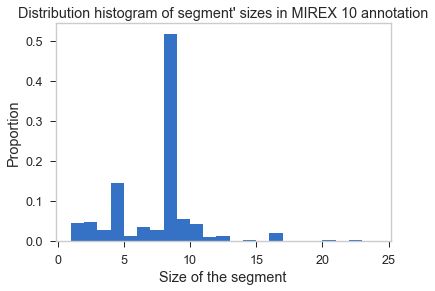

In [4]:
hide.repartition_bar_lengths_RWCPop()

We see in this histogram that most of the segment (more than a half) last 8 bars, and that numerous other segments last 4 bars. The other values are less represented. Hence, it should be interesting to enforce these sizes in our algorithm. 

Thus, we modified our algorithm to include a regularization function, which favoures certain sizes of segments.

This regularization function only depends on the size of the segment, and is subtracted to the convolution cost. Hence, it's a penalty added to the raw convolution cost. Denoting $c_{b_1, b_2}$ the convolution cost as defined previously (see Notebook 1 or the Appendix which details our algorithm), the "regularized" cost is defined as $c'_{b_1,b_2} = c_{b_1,b_2} - \lambda p(b_2 - b_1 + 1) c_{k8}^{max}$, with:
 - $p(b_2 - b_1 + 1)$ the regularization function, which we will present in next part,
 - $\lambda$, a ponderation to handle the influence of this function,
 - $c_{k8}^{max}$, which represents the maximal convolution score on all intervals of size 8 of the current song, and its associated autosimilarity matrix. The idea of this score is to adapt the penalty to the specific shape of this autosimilarity. It can analogously be seen as a normalization of the raw convolution score: $\frac{c_{b_1,b_2}}{ c_{k8}^{max}} - \lambda p(b_2 - b_1 + 1)$

In this notebook, we will try to define the function $p$ and to study the influence of the parameter $\lambda$.

# Definition of the regularization functions

We developped two types of regularization functions:
 - **Symmetric functions centered on 8, as in [1]**: the idea of this method is to favoure segments lasting 8 bars, as the majority of segments have this size, and to penalize all the other segments as the difference between their size and 8, raised to a certain power. Concretely, this results in:
 
    $p(n) = |n - 8| ^{\alpha}$ 
    
    with $n$ the size of the segment. Here, $\alpha$ is a parameter, and we will try
     - $\alpha = \frac{1}{2}$
     - $\alpha = 1$
     - $\alpha = 2$
     
 - **"Modulo functions"**: the idea of this method is to enforce specific sizes of segments, based on prior knowledge. They may be more empirical, but are also more adaptable to the need. Our main idea when developping this function was to favoure 8 wihout penalizing too much 4 or 16, that we know are current sizes (especially 4 in RWC Pop, as shown above). In addition, we considered that segments of even sizes should appear more often than segments of odd sizes in western pop music, which is less obvious in the distribution from above.
 
     We will try 3 different types of function:
     - "Favouring modulo 4": in this case:
         - if $n \equiv 0 \pmod 4, p(n) = 0$,
         - else, if $n \equiv 0 \pmod 2, p(n) = \frac{1}{2}$,
         - else, $p(n) = 1$.
     - "Favouring 8, then modulo 4": in this case:
         - if $n = 8, p(n) = 0$,
         - else, if $n \equiv 0 \pmod 4, p(n) = \frac{1}{4}$,
         - else, if $n \equiv 0 \pmod 2, p(n) = \frac{1}{2}$,
         - else, $p(n) = 1$.
     - "Favouring little segments of 8, then 4": in this case:
         - if $n > 12, p(n) = 100$ (we forbid the algorithm to select segments lasting more than 12 bars),
         - else, if $n = 8, p(n) = 0$,
         - else, if $n \equiv 0 \pmod 4, p(n) = \frac{1}{4}$,
         - else, if $n \equiv 0 \pmod 2, p(n) = \frac{1}{2}$,
         - else, $p(n) = 1$.

We will now test all these functions on the entire RWC Pop database.
 - First, we will fix the ranks to $T' = 32$ (rank for factor $H$) and $B' = 32$ (rank for factor $Q$), and search for the best $\lambda$ in this condition. **In this condition, scores will only be plotted for the tolerance window of 0.5 seconds**.
 - Secondly, we will keep the best parameter $\lambda$ for the ranks 32,32, and we will try several values of ranks with this $\lambda$ fixed. **In this condition, we will show scores with both tolerances 0.5 seconds and 3 seconds, in that order**.
 
 

As stated in the previous notebook, we now fix the subdivision to 96.

In [2]:
subdivision = 96

# Estimating $\lambda$, with fixed ranks $T' = 32$ and $B' = 32$

## Symmetric functions centered on 8

### $\alpha = \frac{1}{2}$

In [8]:
param_range = [i/100 for i in range(0,100,5)]
hide.convolution_parameter_on_all_rwc(param_range, subdivision = subdivision, penalty_func = "sargentdemi")

,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
0.0,10.94,11.81,7.87,0.487,0.5922,0.5256
0.05,10.48,9.87,8.33,0.5223,0.5663,0.5344
0.1,10.22,8.71,8.59,0.5452,0.5514,0.541
0.15,10.01,7.9,8.8,0.5632,0.5403,0.5446
0.2,9.85,7.25,8.96,0.5789,0.5307,0.5475
0.25,9.72,6.75,9.09,0.5906,0.5231,0.5491
0.3,9.59,6.41,9.22,0.5987,0.5159,0.549
0.35,9.53,6.35,9.28,0.6004,0.5146,0.5489
0.4,9.46,6.16,9.35,0.6057,0.5115,0.5498
0.45,9.39,6.26,9.42,0.6017,0.5076,0.5459


For $\alpha = \frac{1}{2}$, the best $\lambda$ (in our range) seems to be **0.4**.

### $\alpha = 1$

In [9]:
param_range = [i/1000 for i in range(0,100, 5)]
hide.convolution_parameter_on_all_rwc(param_range, subdivision = subdivision, penalty_func = "sargentun")

,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
0.0,10.94,11.81,7.87,0.487,0.5922,0.5256
0.005,10.8,11,8.01,0.5007,0.584,0.5301
0.01,10.69,10.6,8.12,0.5079,0.5783,0.5318
0.015,10.59,10.29,8.22,0.5139,0.5724,0.5326
0.02,10.55,10.02,8.26,0.5185,0.57,0.5343
0.025,10.48,9.79,8.33,0.5232,0.5657,0.5353
0.03,10.48,9.57,8.33,0.5288,0.5658,0.5387
0.035,10.31,9.33,8.5,0.5312,0.5568,0.5362
0.04,10.18,9.17,8.63,0.5318,0.5498,0.5334
0.045,10.09,9.02,8.72,0.5334,0.5443,0.5315


For $\alpha = 1$, the best $\lambda$ seems to be **0.09**.

### $\alpha = 2$

In [10]:
param_range = [i/1000 for i in range(0,20)]
hide.convolution_parameter_on_all_rwc(param_range, subdivision = subdivision, penalty_func = "sargentdeux")

,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
0.0,10.94,11.81,7.87,0.487,0.5922,0.5256
0.001,10.81,11.01,8,0.5017,0.5841,0.531
0.002,10.67,10.71,8.14,0.5052,0.5769,0.5302
0.003,10.6,10.49,8.21,0.5088,0.5729,0.5307
0.004,10.58,10.33,8.23,0.5124,0.5712,0.5325
0.005,10.46,10.08,8.35,0.5155,0.5647,0.5318
0.006,10.31,9.89,8.5,0.5167,0.5571,0.5296
0.007,10.26,9.69,8.55,0.52,0.554,0.5305
0.008,10.15,9.69,8.66,0.5175,0.5475,0.5265
0.009,10.06,9.59,8.75,0.5179,0.5419,0.5243


For $\alpha = 2$, the best $\lambda$ seems to be **0.004**.

## Modulo functions

### "Favouring modulo 4"

In [4]:
param_range = [i/10 for i in range(0,20)]
hide.convolution_parameter_on_all_rwc(param_range, subdivision = subdivision, penalty_func = "modulo4")

C:\Users\amarmore\Desktop\Projects\PhD main projects\On Git\Code\Tensor factorization\sample\autosimilarity_segmentation.py:44: RuntimeWarning: invalid value encountered in true_divide
  this_array = np.array([list(i/np.linalg.norm(i)) for i in this_array.T]).T


,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
0.0,10.94,11.81,7.87,0.487,0.5922,0.5256
0.1,10.87,10.3,7.94,0.5186,0.5877,0.5422
0.2,10.72,9.3,8.09,0.5409,0.5794,0.5507
0.3,10.76,8.38,8.05,0.5675,0.5802,0.5652
0.4,10.63,7.8,8.18,0.5804,0.5737,0.5688
0.5,10.4,7.67,8.41,0.5773,0.5607,0.5614
0.6,10.38,7.27,8.43,0.5888,0.5589,0.5667
0.7,10.22,7.23,8.59,0.5866,0.5499,0.5608
0.8,10.26,7,8.55,0.595,0.5527,0.5662
0.9,10.27,6.79,8.54,0.6019,0.5534,0.5699


In this function, the best $\lambda$ seems to be **0.9**.

### "Favouring 8, then modulo 4"

In [5]:
param_range = [i/10 for i in range(0,20)]
hide.convolution_parameter_on_all_rwc(param_range, subdivision = subdivision, penalty_func = "modulo8")

,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
0.0,10.94,11.81,7.87,0.487,0.5922,0.5256
0.1,10.81,10.2,8,0.5201,0.5846,0.5415
0.2,10.65,9.26,8.16,0.5417,0.5757,0.5487
0.3,10.69,8.36,8.12,0.5673,0.5771,0.5632
0.4,10.44,7.79,8.37,0.5766,0.5627,0.5617
0.5,10.31,7.47,8.5,0.5827,0.554,0.5607
0.6,10.22,7.07,8.59,0.5932,0.5483,0.563
0.7,10.06,6.97,8.75,0.5916,0.5414,0.5587
0.8,10.08,6.71,8.73,0.6013,0.5428,0.564
0.9,10.08,6.35,8.73,0.6136,0.542,0.5694


In this function, the best $\lambda$ seems to be **1**.

### "Favouring little segments of 8, then 4"

In [7]:
param_range = [i/10 for i in range(0,20)]
hide.convolution_parameter_on_all_rwc(param_range, subdivision = subdivision, penalty_func = "moduloFrederic")

,Vrai Positifs,Faux Positifs,Faux Négatifs,Precision,Rappel,F mesure
0.0,10.94,11.81,7.87,0.487,0.5922,0.5256
0.1,11.01,12.83,7.8,0.4675,0.5944,0.5173
0.2,10.91,11.87,7.9,0.4871,0.5891,0.5265
0.3,10.8,10.99,8.01,0.5028,0.5827,0.5333
0.4,10.62,10.59,8.19,0.5075,0.5723,0.5324
0.5,10.53,10.2,8.28,0.5132,0.5653,0.5328
0.6,10.49,9.84,8.32,0.5213,0.5626,0.536
0.7,10.48,9.5,8.33,0.5293,0.5623,0.5405
0.8,10.51,9.21,8.3,0.5376,0.5637,0.5456
0.9,10.5,8.92,8.31,0.5448,0.5626,0.549


In this function, the best $\lambda$ seems to be **1**.

# Results with different ranks, $\lambda$ fixed

Now, we will fix $\lambda$ to the previous optimal value, and try different ranks for the decomposition.

For both $H$ and $Q$, we will try ranks in the range [12,16,20,24,28,32,36].

In [5]:
ranks_rhythm = [12,16,20,24,28,32,36]
ranks_pattern = [12,16,20,24,28,32,36]

Note: I conceed that tables are a bit long, you can jump directly to the conclusion to see what we considered to be the best outputs, and check if it's coherent in the tables afterwards.

## Symmetric functions centered on 8

### $\alpha = 1/2$

In [18]:
zero_five_chr, three_chr = hide.compute_ranks_RWC(ranks_rhythm,ranks_pattern,subdivision=subdivision, 
                                                  penalty_weight = 0.4, penalty_func = "sargentdemi")

### $\alpha = 1$

In [6]:
zero_five_chr, three_chr = hide.compute_ranks_RWC(ranks_rhythm,ranks_pattern,subdivision=subdivision, 
                                                  penalty_weight = 0.09, penalty_func = "sargentun")

*NB: results of this particular algorithm were lost, so I recomputed them, explaining the little different in results compared to ones when fitting the $\lambda$ parameter, as code was modified in between.*

### $\alpha = 2$

In [20]:
zero_five_chr, three_chr = hide.compute_ranks_RWC(ranks_rhythm,ranks_pattern,subdivision=subdivision, 
                                                  penalty_weight = 0.004, penalty_func = "sargentdeux")

## Modulo functions

### "Favouring modulo 4"

In [14]:
zero_five_chr, three_chr = hide.compute_ranks_RWC(ranks_rhythm,ranks_pattern, subdivision=subdivision,
                                                  penalty_weight = 0.9, penalty_func = "modulo4")

### "Favouring 8, then modulo 4"

In [15]:
zero_five_chr, three_chr = hide.compute_ranks_RWC(ranks_rhythm,ranks_pattern, subdivision=subdivision,
                                                  penalty_weight = 1, penalty_func = "modulo8")

### "Favouring little segments of 8, then 4"

In [17]:
zero_five_chr, three_chr = hide.compute_ranks_RWC(ranks_rhythm,ranks_pattern, subdivision=subdivision,
                                                  penalty_weight = 1, penalty_func = "moduloFrederic")

# Conclusion

In conclusion, we systematically found that our best results at 0.5 seconds with the modulo functions are higher than the ones obtained with the symmetric functions centered on 8 (either when varying $\lambda$ or the ranks). At 3 seconds, it is less clear whether there is a best function, as best results are generally close.

In that sense, we chose to keep only the modulo functions, and more particularily "favouring 8, then modulo 4", as it gave the best results in this category (especially at 0.5 seconds).

# References

[1] Sargent, G., Bimbot, F., & Vincent, E. (2016). Estimating the structural segmentation of popular music pieces under regularity constraints. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 25(2), 344-358.